In [1]:
%pip install pyarrow rulefit

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
Note: you may need to restart the kernel to use updated packages.


In [44]:
%pip install git+https://github.com/christophM/rulefit.git

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
  Cloning https://github.com/christophM/rulefit.git to /tmp/pip-req-build-1q5qwhxf
  Running command git clone -q https://github.com/christophM/rulefit.git /tmp/pip-req-build-1q5qwhxf
  Created wheel for RuleFit: filename=RuleFit-0.3-py3-none-any.whl size=8788 sha256=a58d83e96514307dac33559dac40da7e99aabad8c732ab5c98a61c0590c2566d
  Stored in directory: /tmp/pip-ephem-wheel-cache-50r3wqkb/wheels/8d/f1/8a/80d74a55f8d14e55f3f1ff050b6f9292abbb0d6de12100e410
Successfully built RuleFit
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
Note: you may need to restart the kernel to use updated packages.


In [19]:
sklearn.__version__

'0.24.1'

In [45]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from plotnine import *
import seaborn as sns

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

import statsmodels.api as sm

import rulefit

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

print('\nok')


ok


In [3]:
# sensitivity:
# min ref_length > 10; < 100
# max n_authors of 50
# cited_by_count > 10; < 100

# by publication year
# solo; 2-author

In [4]:
raw_df = pd.read_feather('data/analysis_df.feather').set_index('id')
raw_df

,is_retracted,publication_year,cited_by_count,ref_length,journal_id,journal_name,n_authors,abstract_indexed,has_doi,has_pmid,concept0,concept1,disrupt,focal_refs,len_I,len_J,novelty_title,novelty_abstract,n_citing
id,,,,,,,,,,,,,,,,,,,
W1000085140,0,2015,8,21,V17140621,Clinical Biochemistry,8,1,1,1,Medicine,None,0.000000,21.0,4.0,4.0,NaN,NaN,8.0
W1000238170,0,2015,23,34,V2764928002,Redox biology,7,1,1,1,Chemistry,Cell biology,0.629630,34.0,22.0,5.0,1.083342,0.644107,27.0
W1000402150,0,2015,1,1,V2764481192,Procedia. Economics and finance,4,1,1,0,Business,None,1.000000,1.0,1.0,0.0,NaN,NaN,1.0
W10005641,0,2013,40,47,V188605413,Carbon,7,1,1,0,None,Optoelectronics,-0.459459,47.0,10.0,27.0,NaN,NaN,37.0
W1000768039,0,2015,50,32,V127530304,Journal of Materials Processing Technology,5,1,1,0,None,None,0.000000,32.0,25.0,25.0,NaN,NaN,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W99822253,1,2012,4,3,V125754415,Proceedings of the National Academy of Science...,7,0,1,1,Medicine,Immunology,1.000000,3.0,3.0,0.0,NaN,NaN,3.0
W998644059,0,2015,4,47,V186231457,Agroforestry Systems,3,1,1,0,Geography,Socioeconomics,-0.500000,47.0,1.0,3.0,NaN,NaN,4.0
W998753227,0,2015,16,38,V186231457,Agroforestry Systems,3,1,1,0,None,None,-0.333333,38.0,6.0,12.0,NaN,NaN,18.0


In [5]:
X_names = 'is_retracted publication_year cited_by_count ref_length n_authors'.split()
Y_names = 'novelty_title novelty_abstract disrupt'.split()
wanted_columns = Y_names + X_names
# df = df[df.disrupt.notna()]
df = raw_df[wanted_columns].copy()
df

,novelty_title,novelty_abstract,disrupt,is_retracted,publication_year,cited_by_count,ref_length,n_authors
id,,,,,,,,
W1000085140,NaN,NaN,0.000000,0,2015,8,21,8
W1000238170,1.083342,0.644107,0.629630,0,2015,23,34,7
W1000402150,NaN,NaN,1.000000,0,2015,1,1,4
W10005641,NaN,NaN,-0.459459,0,2013,40,47,7
W1000768039,NaN,NaN,0.000000,0,2015,50,32,5
...,...,...,...,...,...,...,...,...
W99822253,NaN,NaN,1.000000,1,2012,4,3,7
W998644059,NaN,NaN,-0.500000,0,2015,4,47,3
W998753227,NaN,NaN,-0.333333,0,2015,16,38,3


<AxesSubplot:xlabel='is_retracted', ylabel='disrupt'>

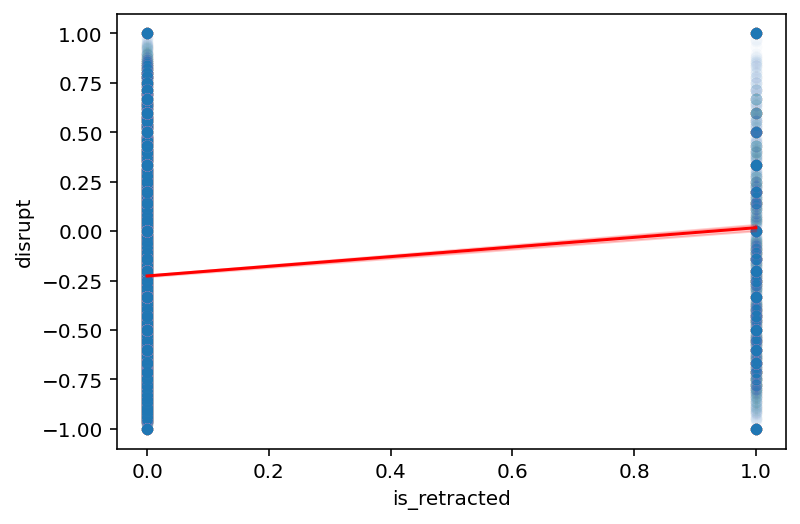

In [6]:
sns.scatterplot(data=df, x='is_retracted', y='disrupt', alpha=0.01)
sns.lineplot(data=df, x='is_retracted', y='disrupt', color='r')

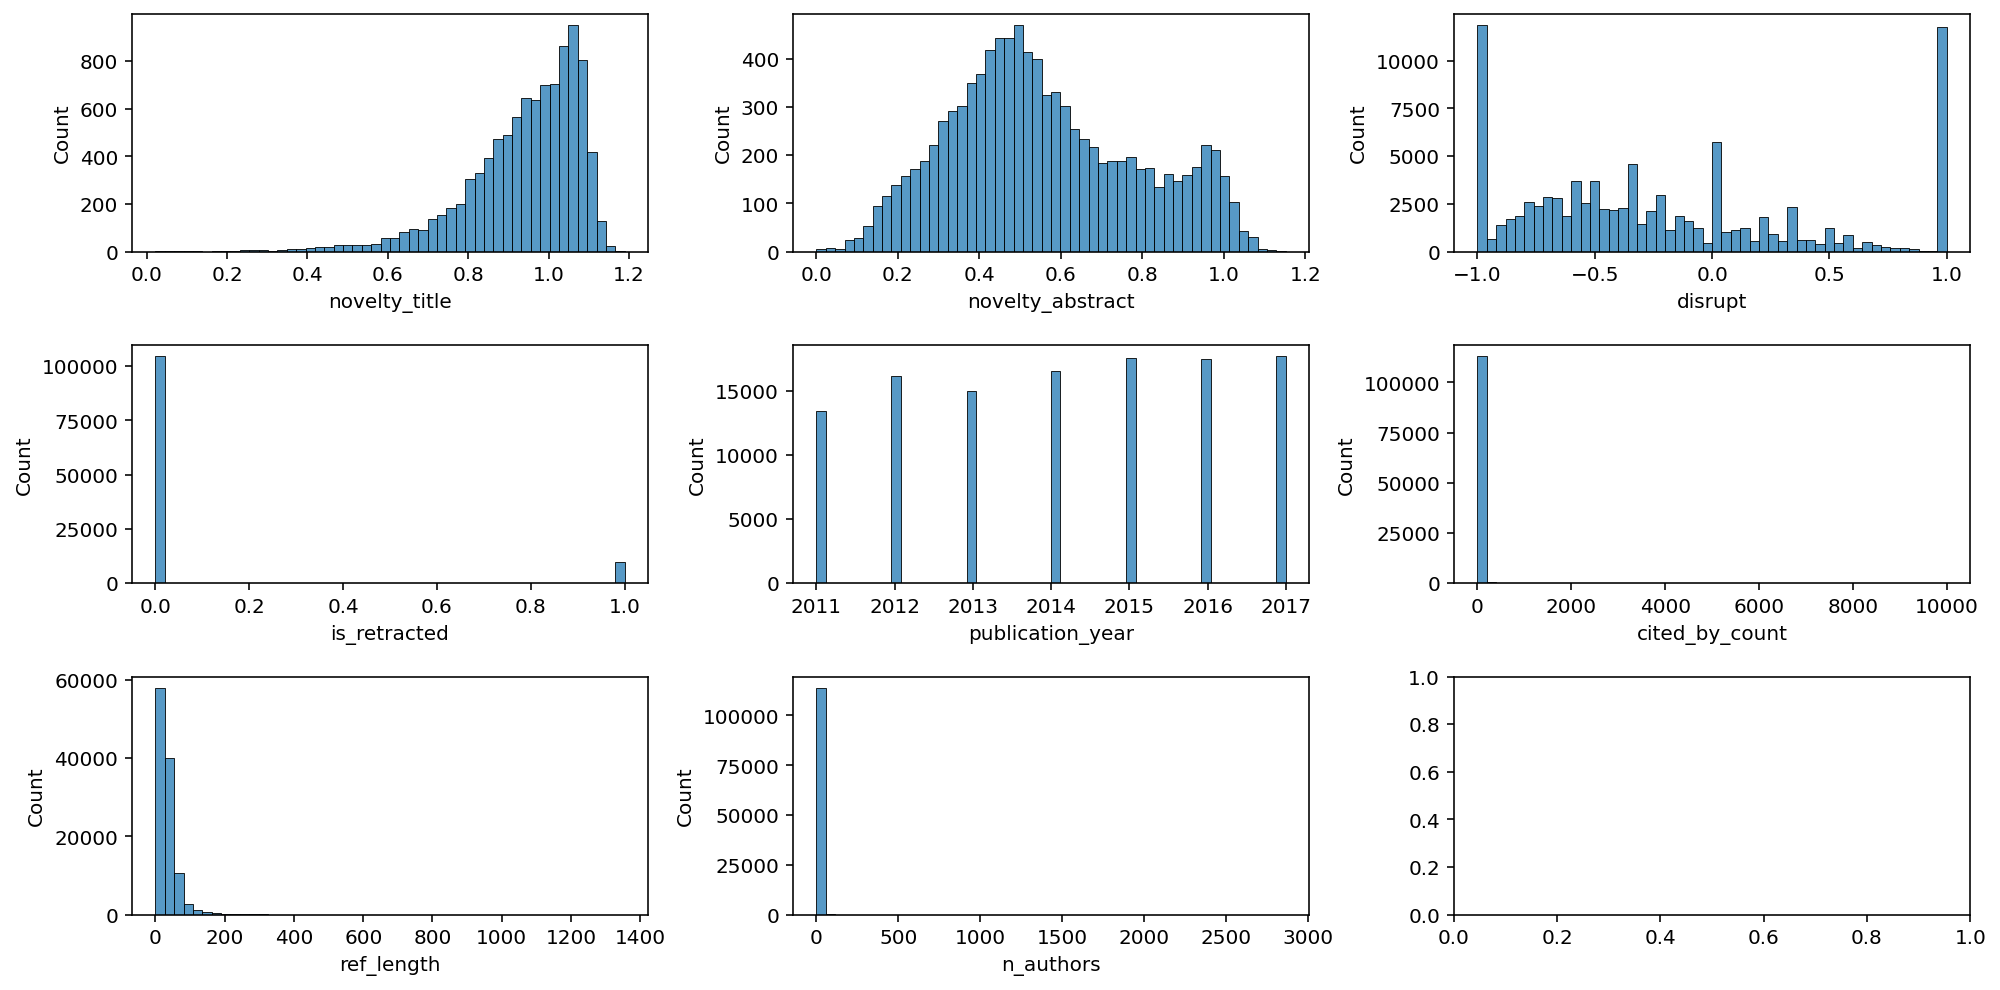

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(14, 7))
for c, ax in zip(df.columns, axes.flat):
    sns.histplot(df[c], bins=50, ax=ax)
plt.tight_layout()

# model selection

In [8]:
df = df[(df.disrupt.notna())]
df

,novelty_title,novelty_abstract,disrupt,is_retracted,publication_year,cited_by_count,ref_length,n_authors
id,,,,,,,,
W1000085140,NaN,NaN,0.000000,0,2015,8,21,8
W1000238170,1.083342,0.644107,0.629630,0,2015,23,34,7
W1000402150,NaN,NaN,1.000000,0,2015,1,1,4
W10005641,NaN,NaN,-0.459459,0,2013,40,47,7
W1000768039,NaN,NaN,0.000000,0,2015,50,32,5
...,...,...,...,...,...,...,...,...
W99822253,NaN,NaN,1.000000,1,2012,4,3,7
W998644059,NaN,NaN,-0.500000,0,2015,4,47,3
W998753227,NaN,NaN,-0.333333,0,2015,16,38,3


In [9]:
X = df[X_names]
y = df.disrupt

In [22]:
ml_models = [
    LinearRegression(),
#     RandomForestRegressor(n_estimators=100, n_jobs=-1),
    RandomForestRegressor(n_estimators=400, n_jobs=-1),
    SGDRegressor(),
    HistGradientBoostingRegressor()
]

In [23]:
# first we do train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [24]:
print("Training")
training = [
    model.fit(X_train, y_train).score(X_train, y_train).mean()
    for model in ml_models
]

Training


In [25]:
for i, model in enumerate(ml_models):
    print(f"M{i} =", training[i])

M0 = 0.09698485575044491
M1 = 0.7518929069844437
M2 = -1.6825780891111349e+30
M3 = 0.3259722119028845


In [26]:
# estimate cross validation performance of each model
print("Validation")
for i, model in enumerate(ml_models):
    print(f"M{i} =", cross_val_score(model, X_train, y_train).mean())

Validation
M0 = 0.0963557344782463
M1 = 0.14883745095542242
M2 = -1.2613319481925737e+30
M3 = 0.3084120376737626


In [35]:
# selected models...
rf_model = ml_models[1]
gb_model = ml_models[3]

print(rf_model)

RandomForestRegressor(n_estimators=400, n_jobs=-1)


In [36]:
gb_model.fit(X_train, y_train)
gb_model.score(X_test, y_test)

0.3140154927574834

In [37]:
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test)

0.1521668784731135

In [30]:
ols = sm.OLS(y, X)
ols_result = ols.fit(cov_type='HC3')
ols_result.params, ols_result.HC3_se, ols_result.conf_int()

(is_retracted        0.225513
 publication_year   -0.000009
 cited_by_count     -0.000005
 ref_length         -0.005655
 n_authors          -0.000874
 dtype: float64,
 is_retracted        0.008118
 publication_year    0.000004
 cited_by_count      0.000060
 ref_length          0.000173
 n_authors           0.000549
 dtype: float64,
                          0         1
 is_retracted      0.209603  0.241423
 publication_year -0.000016 -0.000002
 cited_by_count   -0.000124  0.000113
 ref_length       -0.005995 -0.005315
 n_authors        -0.001951  0.000202)

In [38]:
#Feature importance based on feature permutation
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
start_time = time.time()
with sklearn.config_context(working_memory=128):
    # can't use n_jobs > 1 because it eats too much memory on S4 server
    rf_pi  = permutation_importance(rf_model, X, y, n_repeats=10, random_state=42, n_jobs=1)
    gb_pi  = permutation_importance(gb_model, X, y, n_repeats=10, random_state=42, n_jobs=1)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 88.688 seconds


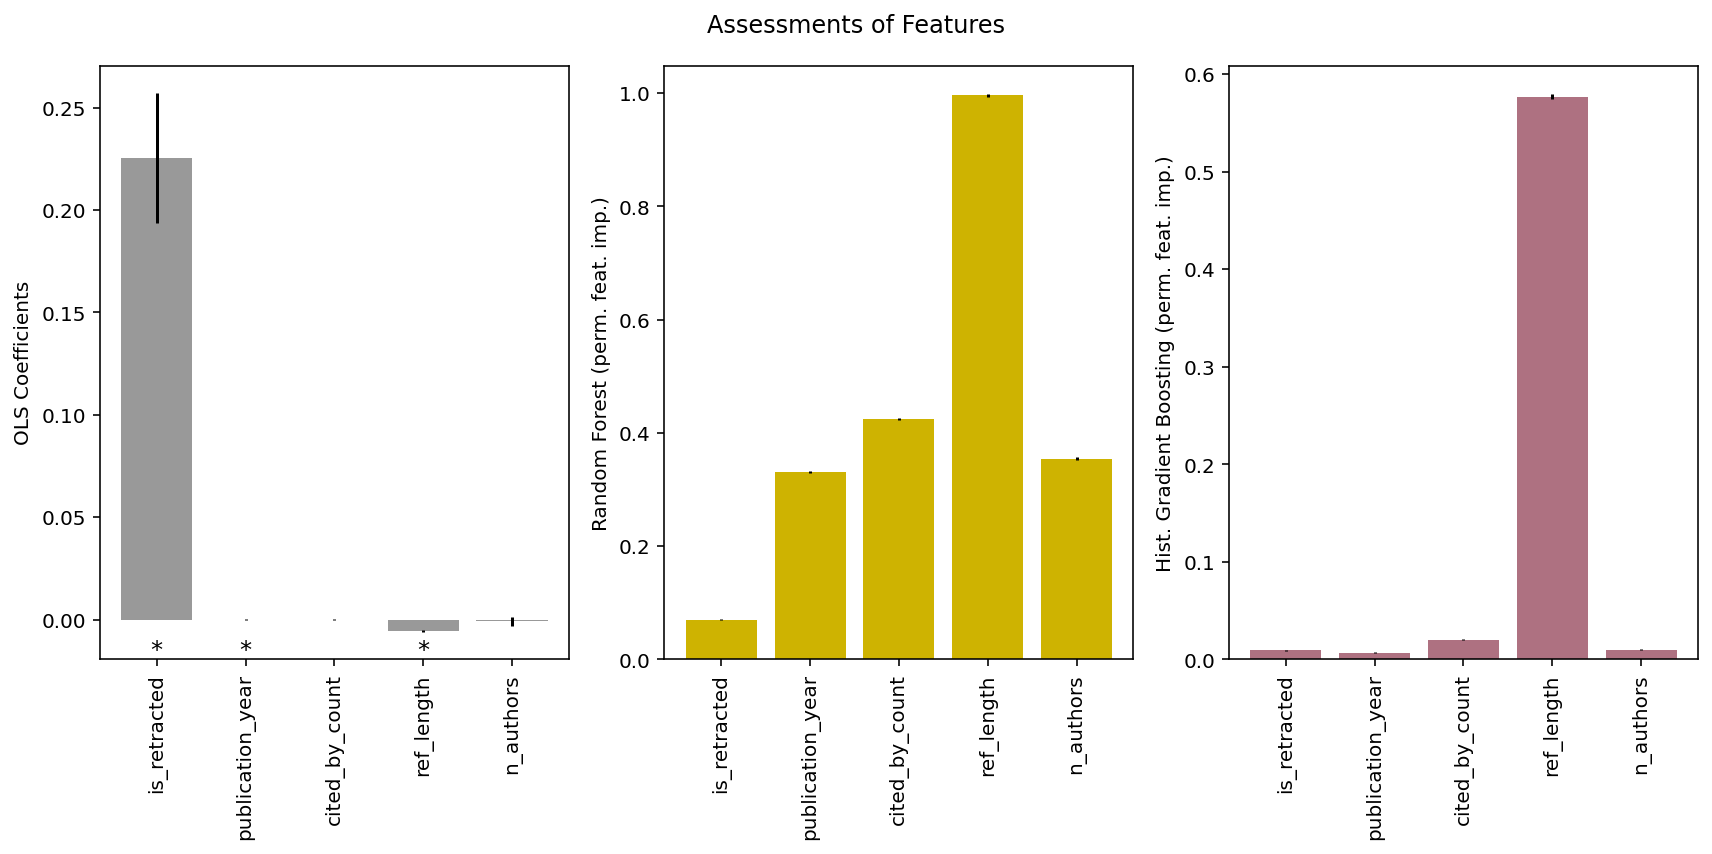

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

ols_err = (ols_result.conf_int()[1] - ols_result.conf_int()[0])
ax1.bar(X_names, ols_result.params, yerr=ols_err, color='#999')
for x, label in enumerate('*' if p < .05 else '' for p in ols_result.pvalues):
    ax1.text(x=x, y=-0.015, s=label, size=12, ha='center', va='center')
ax1.set_ylabel("OLS Coefficients")
ax2.bar(X_names, rf_pi.importances_mean, yerr=rf_pi.importances_std, color='#ceb301')
ax2.set_ylabel("Random Forest (perm. feat. imp.)")
ax3.bar(X_names, gb_pi.importances_mean, yerr=gb_pi.importances_std, color='#ae7181')
ax3.set_ylabel("Hist. Gradient Boosting (perm. feat. imp.)")
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
fig.suptitle("Assessments of Features")
fig.tight_layout() # blows out figsize with suptitle
plt.show()